In [1]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Product Description Generator

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/language/examples/reference-architectures/question_answering_with_large_documents.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/language/examples/reference-architectures/question_answering_with_large_documents.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/blob/main/language/examples/reference-architectures/question_answering_with_large_documents.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Overview

This notebook is a use-case demonstration of creating product descriptions from images. In this notebook, we are using Fashion Image Dataset: https://github.com/alexeygrigorev/clothing-dataset-small to create product descriptions for the clothing images.
As an initial step, we will be deploying the pre-trained [BLIP Image Captioning](https://huggingface.co/Salesforce/blip-image-captioning-base) model on Vertex AI for online prediction. Then we will use the model to caption the images we have. Later, we will use these product image captions to produce product descriptions using PaLM model.

### Objective

- Upload the model to [Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).
- Deploy the model on [Endpoint](https://cloud.google.com/vertex-ai/docs/predictions/using-private-endpoints).
- Run online predictions for image captioning.
- Run online predictions for PaLM model with the image captions to produce product descriptions.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Getting Started

### Install Vertex AI SDK

In [1]:
!pip install google-cloud-aiplatform --upgrade --quiet --user

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


**Colab only**: Uncomment the following cell to restart the kernel. For Vertex AI Workbench you can restart the terminal using the button on top.

In [ ]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

### Authenticating your notebook environment
* If you are using **Colab** to run this notebook, uncomment the cell below and continue.
* If you are using **Vertex AI Workbench**, check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).

In [2]:
# from google.colab import auth as google_auth
# google_auth.authenticate_user()

### Import libraries

**Colab only:** Uncomment the following cell to initialize the Vertex AI SDK. For Vertex AI Workbench, you don't need to run this.

In [ ]:
# import vertexai

# PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
# vertexai.init(project=PROJECT_ID, location="us-central1")

In [39]:
import base64
import os
from datetime import datetime
from io import BytesIO
from google.cloud import storage
import io
from PIL import Image
import requests
from vertexai.preview.language_models import (TextEmbeddingModel,
                                              TextGenerationModel)

### Import models

In [40]:
generation_model = TextGenerationModel.from_pretrained("text-bison@001")

### The following GCS Bucket contains some fashion product image dataset samples

In [30]:
GCS_BUCKET = "github-repo"

### View all the images in the GCS Bucket

In [35]:
! gsutil ls gs://$GCS_BUCKET/product_img/

gs://github-repo/product_img/
gs://github-repo/product_img/fashion1.jpeg
gs://github-repo/product_img/fashion2.jpeg
gs://github-repo/product_img/fashion3.jpeg
gs://github-repo/product_img/fashion4.jpeg
gs://github-repo/product_img/fashion5.jpeg
gs://github-repo/product_img/fashion6.jpeg
gs://github-repo/product_img/fashion7.jpeg
gs://github-repo/product_img/fashion8.jpeg


### Define constants

In [5]:
# The pre-built serving docker image. It contains serving scripts and models.
SERVE_DOCKER_URI = "us-docker.pkg.dev/vertex-ai-restricted/vertex-vision-model-garden-dockers/pytorch-transformers-serve"

### Define common functions

In [15]:
def create_job_name(prefix):
    user = os.environ.get("USER")
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    job_name = f"{prefix}-{user}-{now}"
    return job_name


def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def image_to_base64(image, format="JPEG"):
    buffer = BytesIO()
    image.save(buffer, format=format)
    image_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return image_str


def base64_to_image(image_str):
    image = Image.open(BytesIO(base64.b64decode(image_str)))
    return image


def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


def deploy_model(model_id, task):
    model_name = "blip-image-captioning"
    endpoint = aiplatform.Endpoint.create(display_name=f"{model_name}-endpoint")
    serving_env = {
        "MODEL_ID": model_id,
        "TASK": task,
    }
    # If the model_id is a GCS path, use artifact_uri to pass it to serving docker.
    artifact_uri = model_id if model_id.startswith("gs://") else None
    model = aiplatform.Model.upload(
        display_name=model_name,
        serving_container_image_uri=SERVE_DOCKER_URI,
        serving_container_ports=[7080],
        serving_container_predict_route="/predictions/transformers_serving",
        serving_container_health_route="/ping",
        serving_container_environment_variables=serving_env,
        artifact_uri=artifact_uri,
    )
    model.deploy(
        endpoint=endpoint,
        machine_type="n1-standard-8",
        accelerator_type="NVIDIA_TESLA_T4",
        accelerator_count=1,
        deploy_request_timeout=1800,
    )
    return model, endpoint

def read_jpeg_image_from_gcs(bucket_name, image_name):
    """Reads a JPEG image from a Google Cloud Storage (GCS) bucket.

    Args:
    bucket_name: The name of the GCS bucket that contains the image file.
    image_name: The name of the image file in the GCS bucket.

    Returns:
    The image file as a PIL Image object.
    """

    # Import the Google Cloud Storage client library.

    # Create a storage client.
    client = storage.Client()

    # Get the bucket object.
    bucket = client.bucket(bucket_name)

    # Get the blob object.
    blob = bucket.blob(image_name)

    # Read the blob to a bytestring.
    image_data = blob.download_as_bytes()

    # Decode the bytestring to a PIL Image object.
    image = Image.open(io.BytesIO(image_data))

    # Return the PIL Image object.
    return image

## Upload and deploy models

This section uploads the pre-trained model to Model Registry and deploys it on the Endpoint with 1 T4 GPU.

The model deployment step will take ~15 minutes to complete.

Once deployed, you can send images to get descriptions.

In [7]:
model, endpoint = deploy_model(
    model_id="Salesforce/blip-image-captioning-base", task="image-to-text"
)

Creating Endpoint
Create Endpoint backing LRO: projects/474775107710/locations/us-central1/endpoints/570932407838965760/operations/1753569519856517120
Endpoint created. Resource name: projects/474775107710/locations/us-central1/endpoints/570932407838965760
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/474775107710/locations/us-central1/endpoints/570932407838965760')
Creating Model
Create Model backing LRO: projects/474775107710/locations/us-central1/models/8432455939600154624/operations/7968537005627801600
Model created. Resource name: projects/474775107710/locations/us-central1/models/8432455939600154624@1
To use this Model in another session:
model = aiplatform.Model('projects/474775107710/locations/us-central1/models/8432455939600154624@1')
Deploying model to Endpoint : projects/474775107710/locations/us-central1/endpoints/570932407838965760
Deploy Endpoint model backing LRO: projects/474775107710/locations/us-central1/endpoints/570932407838965760

In [44]:
def generate_product_description(model, image_caption, temperature=0):
    """Ideation example with a Large Language Model"""
    prompt_prefix = 'You work for an online retailer. Generate a product description with from the following keywords: '
    prompt = prompt_prefix + image_caption
    response = model.predict(
        prompt,
        temperature=temperature,
        max_output_tokens=256,
        top_k=40,
        top_p=.8,
    )
    return response.text

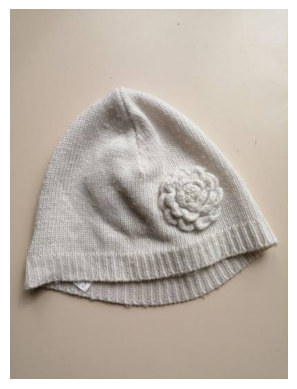

['a white knit hat with a flower on it']
**White Knit Hat with Flower**

This white knit hat is a stylish and comfortable addition to any winter wardrobe. The soft, acrylic yarn is perfect for keeping your head warm, and the flower embellishment adds a touch of feminine flair. The hat is adjustable, so you can find the perfect fit.

**Features:**

* White knit hat
* Soft, acrylic yarn
* Adjustable
* Flower embellishment

**Benefits:**

* Keeps your head warm
* Comfortable to wear
* Stylish and feminine
* Perfect for winter

**How to wear:**

This hat can be worn with a variety of winter outfits. Pair it with a coat, scarf, and boots for a classic winter look. You can also dress it up with a dress or skirt for a more formal occasion.

**Care instructions:**

Hand wash cold, lay flat to dry.

**Order your white knit hat today and stay warm and stylish all winter long!**


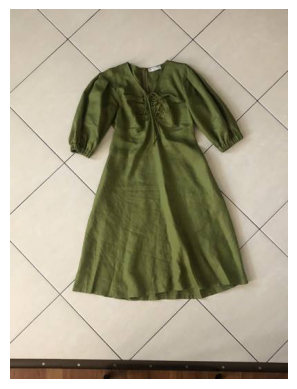

['a green dress hanging on a wall']
The green dress is a beautiful piece of clothing that will make you look stunning. It is made of a soft, lightweight fabric that will keep you comfortable all day long. The dress has a fitted bodice and a flared skirt that will flatter your figure. The dress is also fully lined, so you can wear it without a slip. The dress is perfect for any occasion, from a casual day out to a special event. It is also easy to care for, just machine wash and dry on low heat.


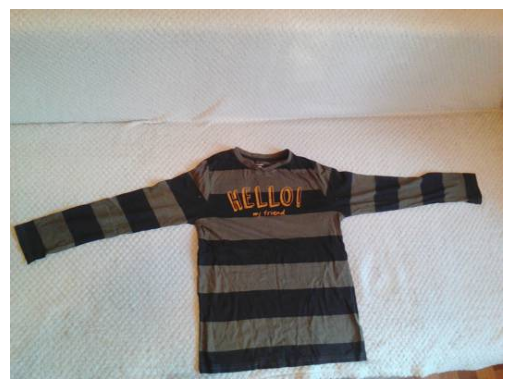

['a shirt that says ` ` ` ` ` ` ` ` ` ` ` ` ` ` `']
This comfortable, cotton t-shirt is perfect for any occasion. It features a bold, graphic print that will make you stand out from the crowd. The shirt is available in a variety of colors and sizes, so you're sure to find the perfect one for you. Order yours today!


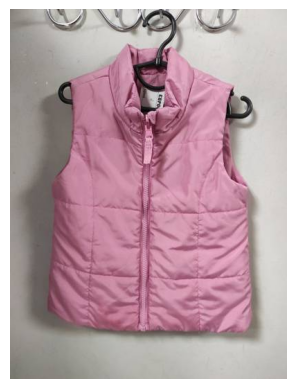

['a pink vest with a black metal hanger']
**Pink Vest with Black Metal Hanger**

This pink vest is a stylish and versatile piece that can be dressed up or down. It features a relaxed fit and a V-neckline, and it's made from a soft, lightweight fabric that's perfect for layering. The vest comes with a black metal hanger, so you can easily display it in your closet.

Here are some of the features of this pink vest:

* Relaxed fit
* V-neckline
* Soft, lightweight fabric
* Black metal hanger

This vest is perfect for a variety of occasions, from casual days to dressy events. You can wear it with jeans and a tee for a relaxed look, or dress it up with a skirt and heels for a more formal occasion.

Order your pink vest today and add a stylish new piece to your wardrobe!


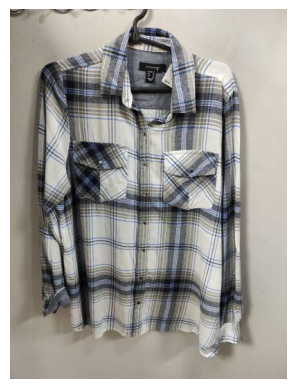

['a white and blue plaid shirt hanging on a wall']
The classic plaid shirt is back and better than ever! This white and blue plaid shirt is made from 100% cotton and features a button-down front, long sleeves, and a relaxed fit. It's perfect for layering over a tee or tank top, or wearing on its own with jeans or shorts. The shirt is also machine-washable and wrinkle-resistant, making it easy to care for. Order yours today and see why the plaid shirt is a wardrobe staple!


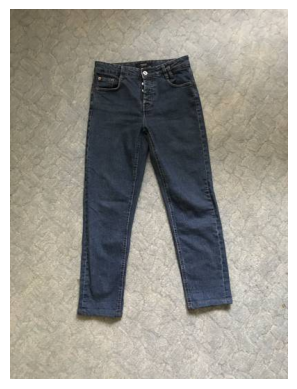

['7 for all mankind jeans']
The 7 for all mankind jeans are a classic pair of denim that will never go out of style. They are made with a high-quality cotton denim that is soft and comfortable to wear. The jeans have a relaxed fit that is flattering to all body types. They also have a slight stretch, which makes them comfortable to move around in. The 7 for all mankind jeans are available in a variety of colors, so you can find the perfect pair to match your style. These jeans are perfect for everyday wear, or for a night out on the town. You'll love the way they look and feel, and they will become a staple in your wardrobe.


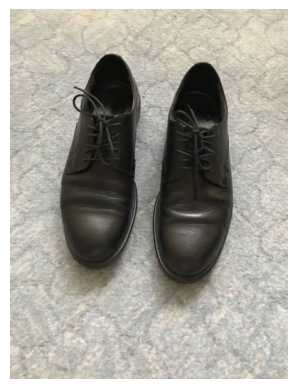

['a pair of black leather shoes']
**A pair of black leather shoes**

These black leather shoes are a classic and stylish choice for any occasion. They are made of high-quality leather and have a comfortable fit. The shoes have a sleek design and will look great with any outfit.

**Features:**

* Made of high-quality leather
* Comfortable fit
* Sleek design
* Perfect for any occasion

**Benefits:**

* These shoes will last for years to come.
* They are comfortable to wear all day long.
* The sleek design will make you look stylish.
* You can wear these shoes with any outfit.

**Order your pair of black leather shoes today!**


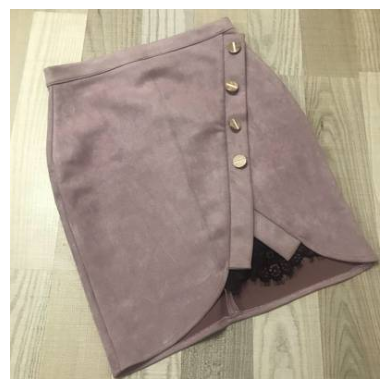

['a purple skirt with a black lace trim']
This purple skirt is a must-have for any woman's wardrobe. It is made of a soft, stretchy fabric that will keep you comfortable all day long. The black lace trim adds a touch of sophistication to the skirt, making it perfect for any occasion. Whether you're going to a party, a night out on the town, or just running errands, this skirt will make you look and feel your best.

Here are some more details about the skirt:

* The skirt is made of a stretchy, wrinkle-resistant fabric.
* It has a high waist and a flared hem.
* The black lace trim is 1 inch wide.
* The skirt is available in sizes XS-XL.
* The skirt is machine-washable.

Order your purple skirt today and see how it can make you look and feel like a million bucks!


In [49]:
from matplotlib import pyplot as plt

for i in range(1,9):
    image_data = read_jpeg_image_from_gcs(GCS_BUCKET, 'product_img/fashion'+str(i)+'.jpeg')
    # Display the image
    plt.imshow(image_data)
    plt.axis('off')
    plt.show()

    instances = [
      {"image": image_to_base64(image_data)},
    ]
    preds = endpoint.predict(instances=instances).predictions
    print(preds)
    product_description = generate_product_description(model=generation_model, image_caption=preds[0])
    print(product_description)